# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
############################################################################################################### 
# Business : Used car market
# Objective: Features affecting the price of the car
# Goal: Model to predict market cost for any used car based on features 
############################################################################################################### 

In [ ]:
############################################################################################################### 
# Logically features which could be possible drivers to influence the price based on priority which can be which
# can be validate against the model built using arious steps of running regression algorithms and check the 
# prediction against actuals 
#### Features Priority ###
# Clear title 
# Condition
# Odometer
# fuel 
# Manufacturer
# Segment(luxary), type and size of the car
###############################################################################################################

In [ ]:
###############################################################################################################
# Planning to group car data based on manaufacturing year to reduce the data involved to run various #######
# algorithms and facilitate analysis as factor of car pricing could be different based on latest model #####
# and older models
############################################################################################################### 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:
###############################################################################################################
# Improve data quality based
# Understand the data types
# Check data miss and impute data based on available logic or sources/libraries 
# Drop all the columns with large null values or not effective for analysis
# Check outliers
# Use the clean data for the analysis
###############################################################################################################


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Read vehicle csv data
cars = pd.read_csv('data/vehicles.csv')
cars.head()

In [ ]:
# Investigate dataset for missing or problematic data
cars.info()

###############################################################################################################
#### Observation #####
# Most features are either ordinal or nominal data & very few features are numeric or float
###############################################################################################################

In [27]:
# Total dataset
cars.shape

(426880, 18)

In [ ]:
# Missing values counts
missing_rows = cars.isnull().sum() 
missing_rows

In [ ]:
# Dictionary of all the unique values corresponding to each object columns
object_cols = cars.select_dtypes(include='object').columns
unique_values = {}
for col in object_cols:
    unique_values[col] = cars[col].unique()

unique_values

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [ ]:
# [Odmoeter] 
### 0.01% missing values 
### null values can be replace by mean of all the records  
cars['odometer'].fillna(cars['odometer'].mean(), inplace= True)

In [ ]:
###############################################################################################################
###  Data impute based on the data releation with other features
###  ~37% of data missing in condition column
###  Conditions are - 'good' 'excellent' 'fair' 'like new' 'new' 'salvage'
###  Add missing data based on following logic
###  1. title_type is exists and equal to 'salvege' then set 'salvage'
###############################################################################################################
cars.loc[cars['title_status'] == 'salvage',['condition']] = 'salvage'

###  2. title_type is exists and equal to 'parts only' then 'unfit'
cars.loc[cars['title_status'] == 'parts only',['condition']] = 'unfit'

###  3. title_type is exists and equal to 'rebuilt' then 'fair'
cars.loc[cars['title_status'] == 'rebuilt',['condition']] = 'fair'

###  4. title_type is exists and equal to 'missing' and odometer <10,000 then 'like new'
cars.loc[(cars['odometer'] < 10000) ,['condition']] = 'like new'

###  4. title_type is exists and equal to 'missing' and odometer > 10,000 -20,000 then 'excellent' 
cars.loc[(((cars['odometer'] > 10000) & (cars['odometer'] < 20000))) ,['condition']] = 'excellent'

###  4. title_type is exists and equal to 'missing' and odometer between 20,000-40,000 'fair'
cars.loc[(((cars['odometer'] > 20000) & (cars['odometer'] < 40000))),['condition']] = 'fair'

###  4. title_type is exists and equal to 'missing' and odometer >40,000 <100000 then 'good'
cars.loc[(((cars['odometer'] > 40000))),['condition']] = 'good'

###  5. Check data improvment and remove all the null rows
#### Remove all rows(#293) with condition 'null' or filled with in-appropriate data
cars.drop(cars[cars['condition'].isnull()].index, inplace= True)

# [title_status]
###  Most important data point for customer  
###  0.02% of the total data is null which can not be produced based on any specific logic 
###  Drop all the rows with null 'title_status'
cars.drop(cars[cars['title_status'].isnull()].index, inplace= True)

# Check missing values counts
missing_rows = cars.isnull().sum() 
missing_rows

In [47]:
car_wt_year_na = cars.loc[(cars['year'].isna()) & (cars['VIN'].notna())]
car_wt_year_na.shape

(892, 18)

In [71]:
###############################################################################################################
# Use VIN as input to enahance the data using external librarary 'vin' which can use to fetch relevent data 
# for 
###############################################################################################################

import vin
from pyvin import VIN
import math

#API and feature upadate statics
stats = {
    "api_failed" : 0,
    "api_invoked": 0,
}

In [ ]:
###############################################################################################################
##  Note: long operation to be Executed once ##
###############################################################################################################

# Set car model year based on car VIN number 
def setYear(row):
    try:
        vehicle = VIN(row.VIN)
        stats['api_invoked'] += 1  # API success metrics
        print(stats['api_invoked']) 
        return vehicle.ModelYear  
    except BaseException:
        stats['api_failed'] =+1 # API failed matrics
        return row.year
    

# Update year column based on the VIN number
# All the samples with year feature missing but have VIN number
car_wt_year_na = cars.loc[(cars['year'].isna()) & (cars['VIN'].notna())]
cars.loc[car_wt_year_na.index, 'year'] = car_wt_year_na.apply(setYear, axis=1)
print(stats)

#Update changes to incremental data csv to keep completed set to reduce time spent for re-initiating the completed transactions
cars.to_csv('data/incremental_modified_data.csv', index= False)



In [ ]:
###############################################################################################################
##  Note: long operation to be Executed once ##
###############################################################################################################

# Set car manufacturer based on car VIN number 
def setManufacturer(row):
    try:
        vehicle = VIN(row.VIN)
        stats['api_invoked'] += 1 # API success metrics 
        return vehicle.Make  
    except BaseException:
        stats['api_failed'] =+1 # Feature failed matrics
        return row.manufacturer
    
# Update manufacturer column based on the VIN number
car_wt_manf_na = cars.loc[(cars['manufacturer'].isna()) & (cars['VIN'].notna())]
cars.loc[car_wt_year_na.index, 'manufacturer'] = car_wt_year_na.apply(setManufacturer, axis=1)
print(stats)

#Update changes to incremental data csv to keep completed set to reduce time spent for re-initiating the completed transactions
cars.to_csv('data/incremental_modified_data.csv', index= False)



In [ ]:
###############################################################################################################
##  Note: long operation to be Executed once ##
###############################################################################################################

# Set car model based on car VIN number 
def setModel(row):
    try:
        vehicle = VIN(row.VIN)
        stats['api_invoked'] += 1 # API success metrics
        print(stats['api_invoked'])  
        return vehicle.Model  
    except BaseException:
        stats['api_failed'] =+1 # Feature failed matrics
        return row.model
    
# Update model column based on the VIN number
car_wt_model_na = cars.loc[(cars['model'].isna()) & (cars['VIN'].notna())]
cars.loc[car_wt_model_na.index, 'model'] = car_wt_model_na.apply(setModel, axis=1)
print(stats)

#Update changes to incremental data csv to keep completed set to reduce time spent for re-initiating the completed transactions
cars.to_csv('data/incremental_modified_data.csv', index= False)



In [ ]:
###############################################################################################################
##  Note: long operation to be Executed once ##
###############################################################################################################

# Set car cylinder based on car VIN number 
def setCylinder(row):
    try:
        vehicle = VIN(row.VIN)
        stats['api_invoked'] += 1 # API success metrics
        print(stats['api_invoked'])  
        return vehicle.EngineCylinders  + " cylinders"
    except BaseException:
        stats['api_failed'] =+1 # Feature failed matrics
        return row.cylinders
    
# Update cylinder column based on the VIN number
car_wt_cylinder_na = cars.loc[(cars['cylinders'].isna()) & (cars['VIN'].notna())]
cars.loc[car_wt_cylinder_na.index, 'cylinders'] = car_wt_cylinder_na.apply(setCylinder, axis=1)
print(stats)

#Update changes to incremental data csv to keep completed set to reduce time spent for re-initiating the completed transactions
cars.to_csv('data/incremental_modified_data.csv', index= False)



In [ ]:
###############################################################################################################
##  Note: long operation to be Executed once ##
###############################################################################################################


# Set car type based on car VIN number 
def setType(row):
    try:
        vehicle = VIN(row.VIN)
        stats['api_invoked'] += 1 # API success metrics
        print(stats['api_invoked'])  
        return vehicle.VehicleType
    except BaseException:
        stats['api_failed'] =+1 # Feature failed matrics
        return row.type

# Update type column based on the VIN number
car_wt_type_na = cars.loc[(cars['type'].isna()) & (cars['VIN'].notna())]
cars.loc[car_wt_type_na.index, 'type'] = car_wt_type_na.apply(setType, axis=1)
print(stats)

#Update changes to incremental data csv to keep completed set to reduce time spent for re-initiating the completed transactions
cars.to_csv('data/incremental_modified_data.csv', index= False)



In [ ]:
###############################################################################################################
##  Note: long operation to be Executed once ##
###############################################################################################################

# Set car type based on car VIN number 
def setDrive(row):
    try:
        drive = ['rwd', '4wd' ,'fwd']
        vehicle = VIN(row.VIN)
        stats['api_invoked'] += 1 # API success metrics
        type = vehicle.DriveType[0:3].lower()
        if type in drive:
            return type
        else:
            return row.drive
    except BaseException:
        stats['api_failed'] =+1 # Feature failed matrics
        return row.drive
    
# Update drive column based on the VIN number
car_wt_drive_na = cars.loc[(cars['drive'].isna()) & (cars['VIN'].notna())]
cars.loc[car_wt_drive_na.index, 'drive'] = car_wt_drive_na.apply(setDrive, axis=1)
print(stats)

#Update changes to incremental data csv to keep completed set to reduce time spent for re-initiating the completed transactions
cars.to_csv('data/incremental_modified_data.csv', index= False)

In [ ]:
# Ordered categories for column 'title_status' and replace column values with category code
title_status_ord = [ 'missing', 'parts only', 'lien', 'salvage','rebuilt', 'clean'  ]
title_status_cat = cars['title_status'].astype('category')
cars['title_status'] = title_status_cat.cat.set_categories(title_status_ord).cat.codes

# Ordered categories for column 'transmission' and replace column values with category code
transmission_ord = ['other', 'manual', 'automatic' ]
transmission_cat = cars['transmission'].astype('category')
cars['transmission'] = transmission_cat.cat.set_categories(transmission_ord).cat.codes

# Ordered categories for column 'condition' and replace column values with category code
condition_ord = ['unfit', 'salvage', 'fair', 'good','excellent' , 'like new' ,'new' ]
condition_cat = cars['condition'].astype('category')
cars['condition'] = condition_cat.cat.set_categories(condition_ord).cat.codes

# Ordered categories for column 'fuel' and replace column values with category code
fuel_ord = ['other', 'diesel', 'gas', 'electric','hybrid']
fuel_cat = cars['fuel'].astype('category')
cars['fuel'] = fuel_cat.cat.set_categories(fuel_ord).cat.codes

In [ ]:
###############################################################################################################
# Observation #
# Large amount of data missing for features 'size' (~75%)  which can not be reproduced. 
# Drop 'year' records which has not been reproduced using VIN transformation
###############################################################################################################
cars.drop(columns='size', axis=1)

#  [year] Drop record(#893) with 'year' field NA
cars.drop(cars[cars['year'].isna()].index, inplace= True)

#  [fuel] Drop record(#1633) with 'fuel' field NA
cars.drop(cars[cars['fuel'].isna()].index, inplace= True)

#  [transmission] Drop record(#1873) with 'transmission' field NA
cars.drop(cars[cars['transmission'].isna()].index, inplace= True)

#  [model] Drop record with 'model' field NA
cars.drop(cars[cars['model'].isna()].index, inplace= True)

#  [odometer] Drop record with 'odometer' field NA
cars.drop(cars[cars['odometer'].isna()].index, inplace= True)

#  [manufacturer] Drop record with 'manufacturer' field NA
cars.drop(cars[cars['manufacturer'].isna()].index, inplace= True)

In [ ]:
###############################################################################################################
# Correct datatypes
# Odometer feature datatype from 'float' to 'int64'.
# Year feature datatype from 'float' to 'int64'
###############################################################################################################
cars['odometer'] = cars['odometer'].astype('int64')
cars['year'] = cars['year'].astype('int64')

In [ ]:
# Group car data based on manaufacturing year starting from 1900(min) to 2022(max)
bins = [1900, 1980, 2000, 2010, 2020, 2025]
labels = ['80s', '2000', '2010', '2020', '2025']
cars['year_bin'] = pd.cut(cars['year'], bins=bins, labels=labels)

# Total number of records based on car manufacturing year
count_gp_by_year = cars.groupby(by='year_bin', axis = 0).count()['id']
print(count_gp_by_year)

In [4]:
### recreate data frame from modified csv 
cars = pd.read_csv("data/incremental_modified_data.csv")

In [5]:
cars.isna().sum()

id                   0
region               0
price                0
year                 0
manufacturer         0
model                0
condition            0
cylinders       161777
fuel                 0
odometer             0
title_status         0
transmission         0
VIN             145663
drive           115035
size            277877
type             82588
paint_color     113157
state                0
year_bin             5
dtype: int64

In [ ]:
###############################################################################################################
## Observation ##
## Number of cars based on year range which most population for 2010-2020 #273,517 & 2000 - 2010 # 104,877
###############################################################################################################


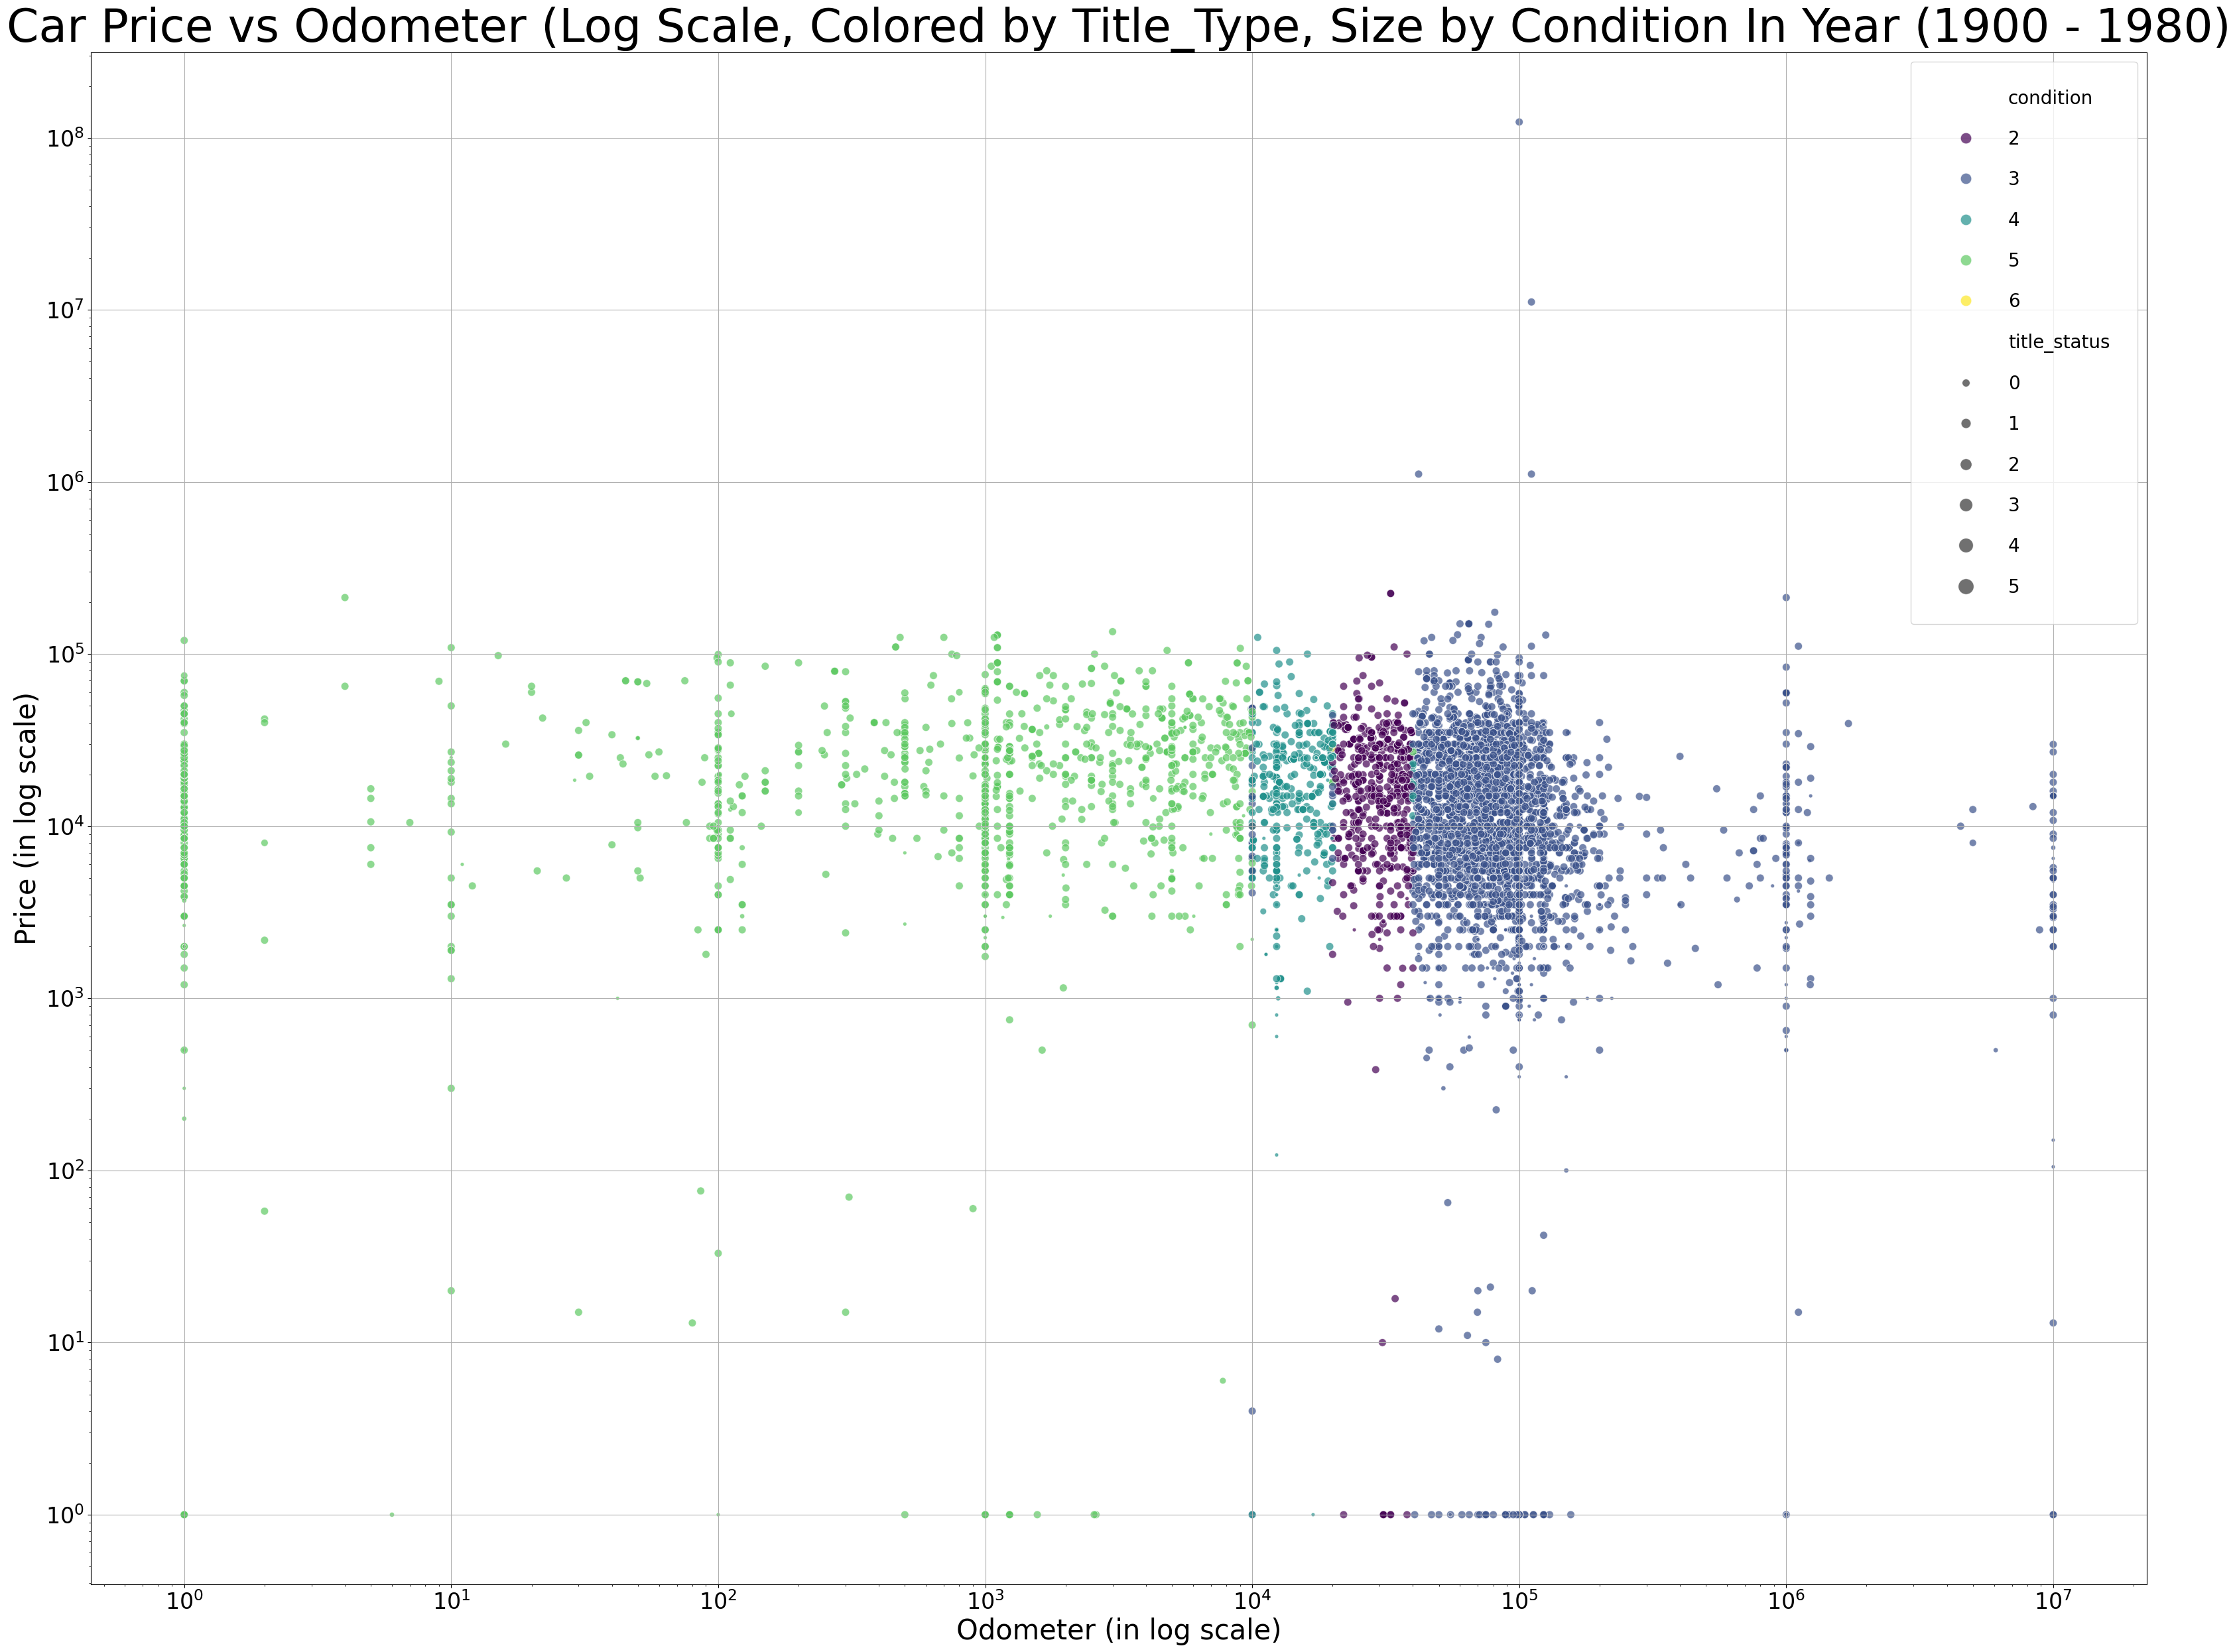

In [130]:

# Scatter plot between Odometer Vs Price Vs title_status to check 
def createScatterPlot(df, period):
    plt.figure(figsize=(40,30))
    ax = sns.scatterplot(df, x='odometer', y='price', 
                         hue='condition', size='title_status',
                          alpha=0.7, 
                         palette='viridis')
    
    ax.set_xlabel('Odometer (in log scale)', fontsize=30)
    ax.set_ylabel('Price (in log scale)', fontsize=30)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()

    # tick Label size setting
    ax.tick_params(axis='both', labelsize=24)

    ax.legend(fontsize=20, markerscale=2.0, handlelength=3, borderpad=1.5, labelspacing=1.2)
    # hue_labels = title_status_ord
    # size_labels = condition_ord

    # # Retrieve current legend handles and labels
    # handles, labels = ax.get_legend_handles_labels()

    # # Create dictionaries for mapping labels to handles
    # handle_dict = dict(zip(labels, handles))

    # # Create legend for 'title status' (hue)
    # hue_handles = [handle_dict[label] for label in hue_labels]
    # legend1 = ax.legend(
    #     handles=hue_handles,
    #     title="Title Status",
    #     loc="upper right",
    #     bbox_to_anchor=(1.05, 1)
    # )

    # ax.add_artist(legend1)

    # # Create legend for 'condition' (size)
    # size_handles = [handle_dict[label] for label in size_labels]
    # legend2 = ax.legend(
    #     handles=size_handles,
    #     title="Smoker",
    #     loc="lower right",
    #     bbox_to_anchor=(1.05, 0)
    # )
    # ax.add_artist(legend2)

    # plt.tight_layout()

    # plot title
    plt.title('Car Price vs Odometer (Log Scale, Colored by Title_Type, Size by Condition In Year (' + period + ")", fontsize=50)
    return plt

# 80's scatter plot with odometer, title_status, condition and price
scatter_plt_80s = createScatterPlot(cars[cars['year_bin'] == '80s'], '1900 - 1980')
scatter_plt_80s.show()

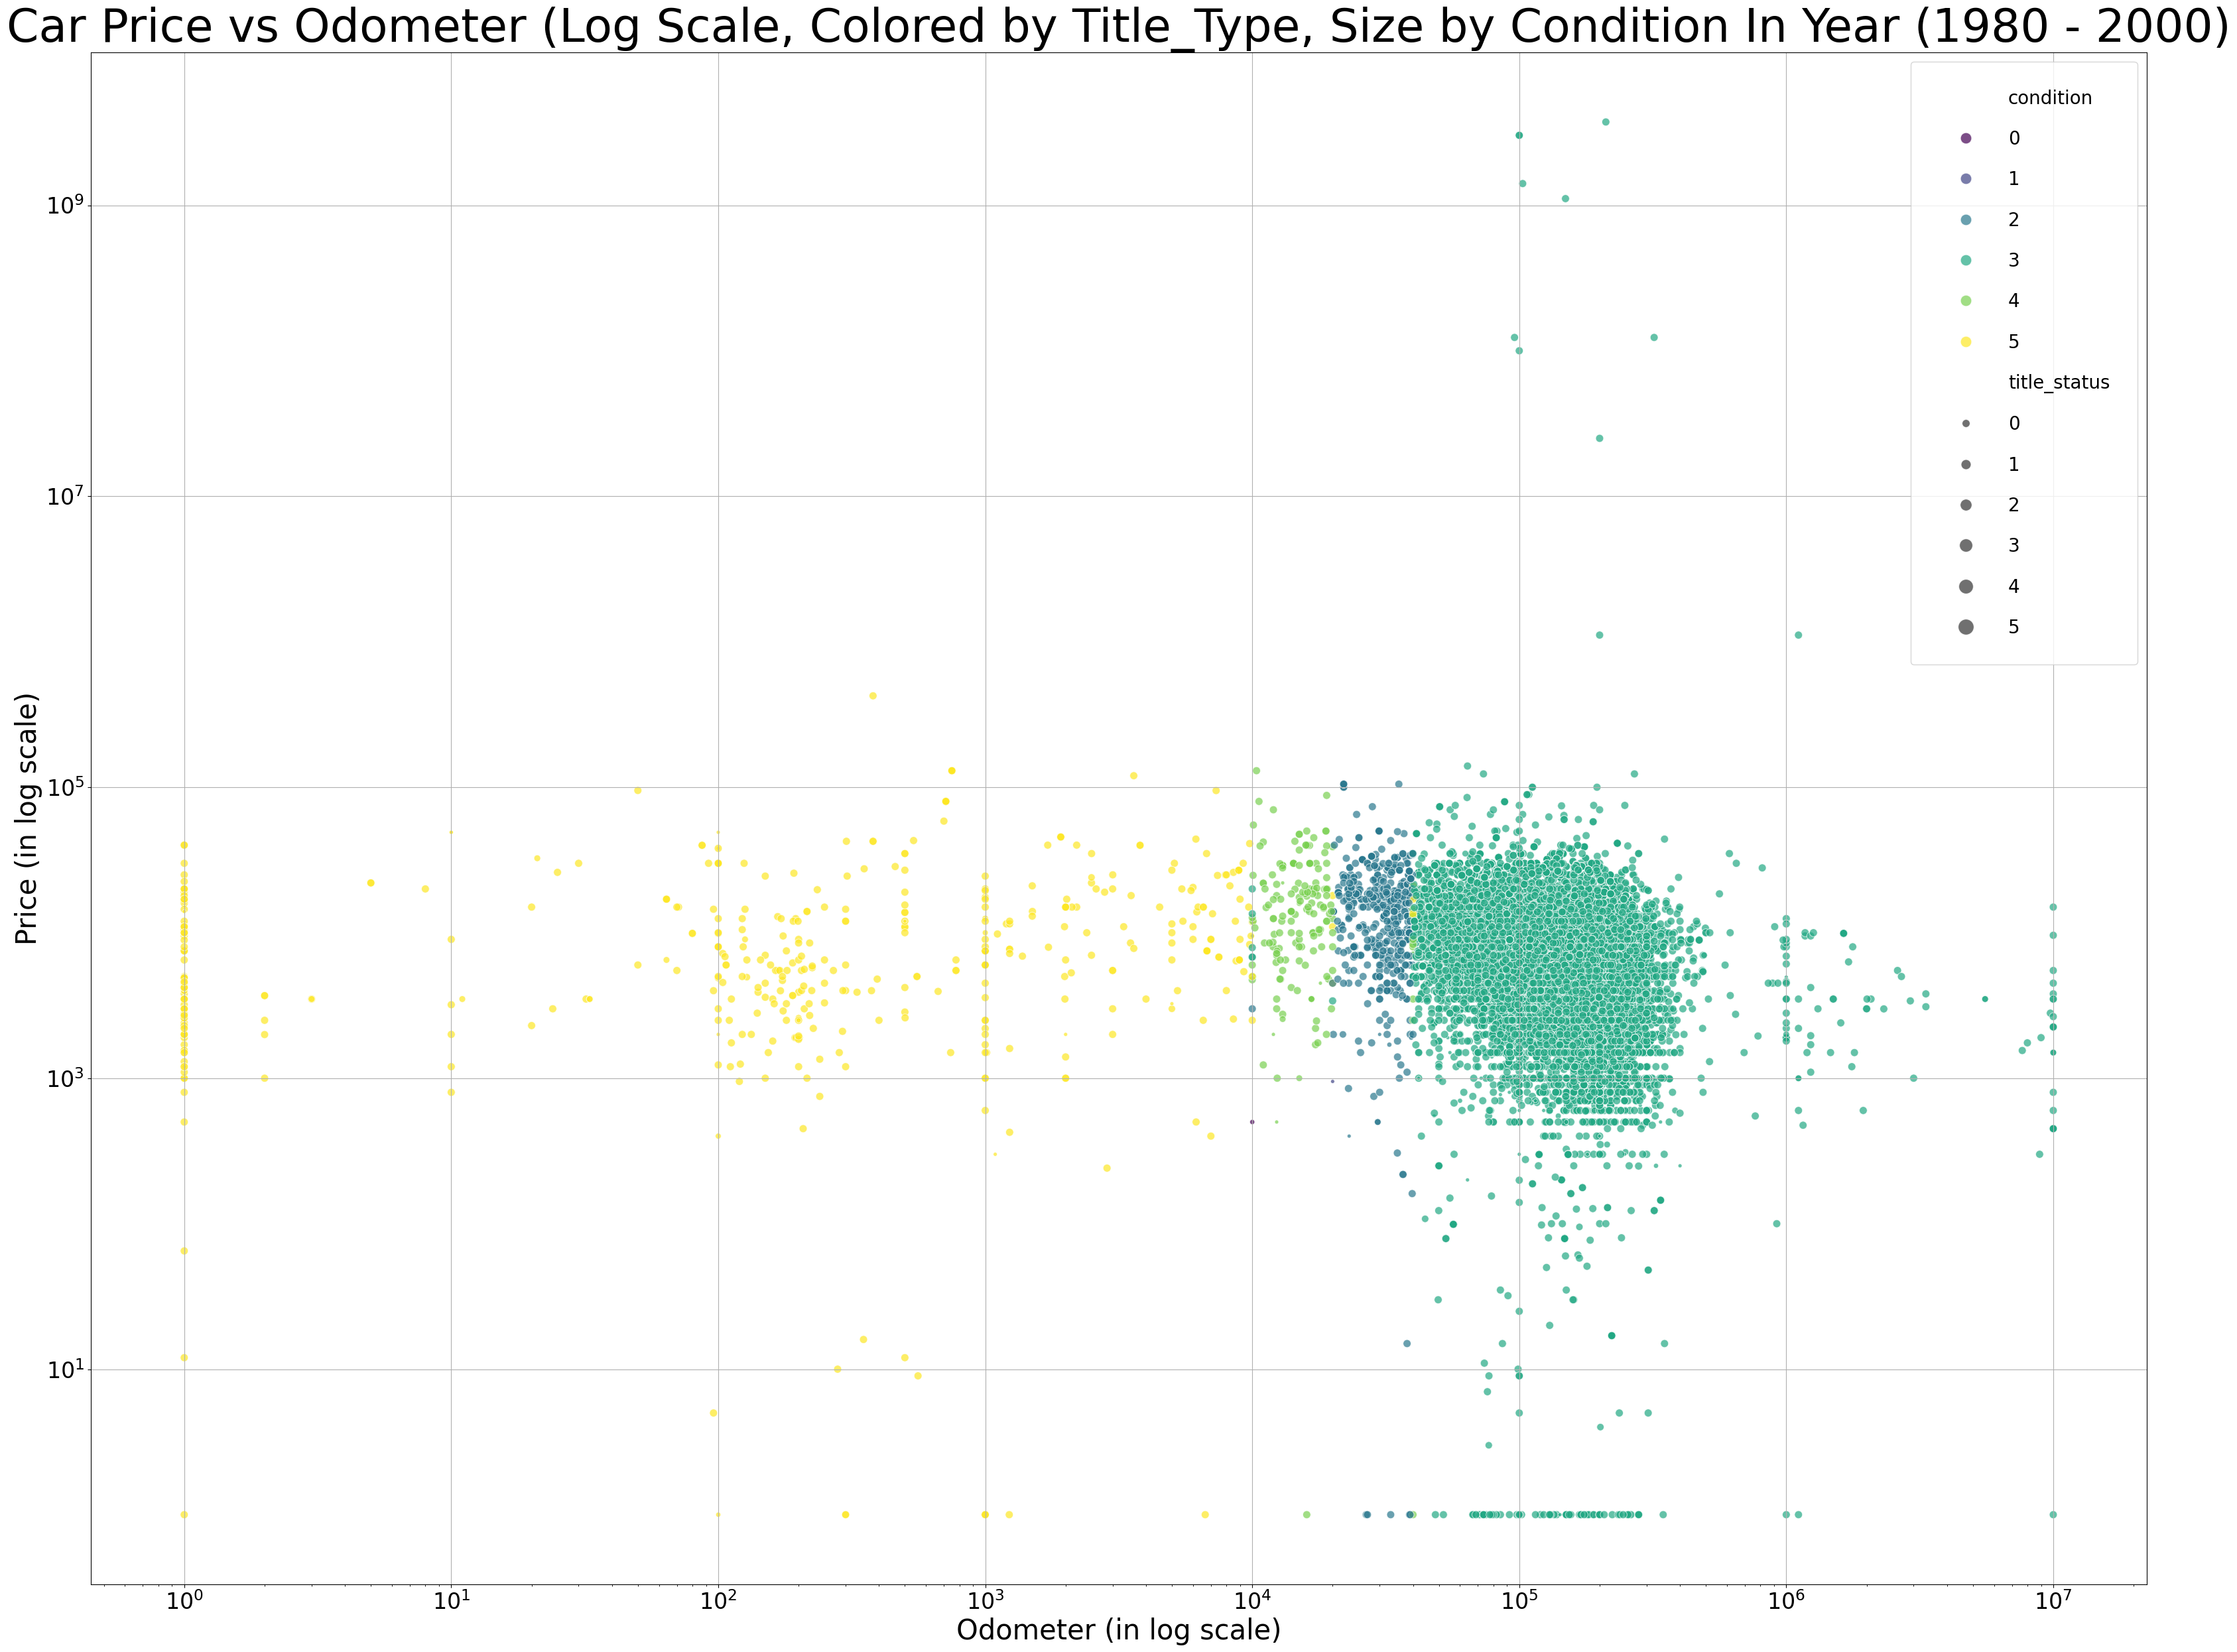

In [131]:
scatter_plt_2000 = createScatterPlot(cars[cars['year_bin'] == '2000'], '1980 - 2000')
scatter_plt_2000.show()

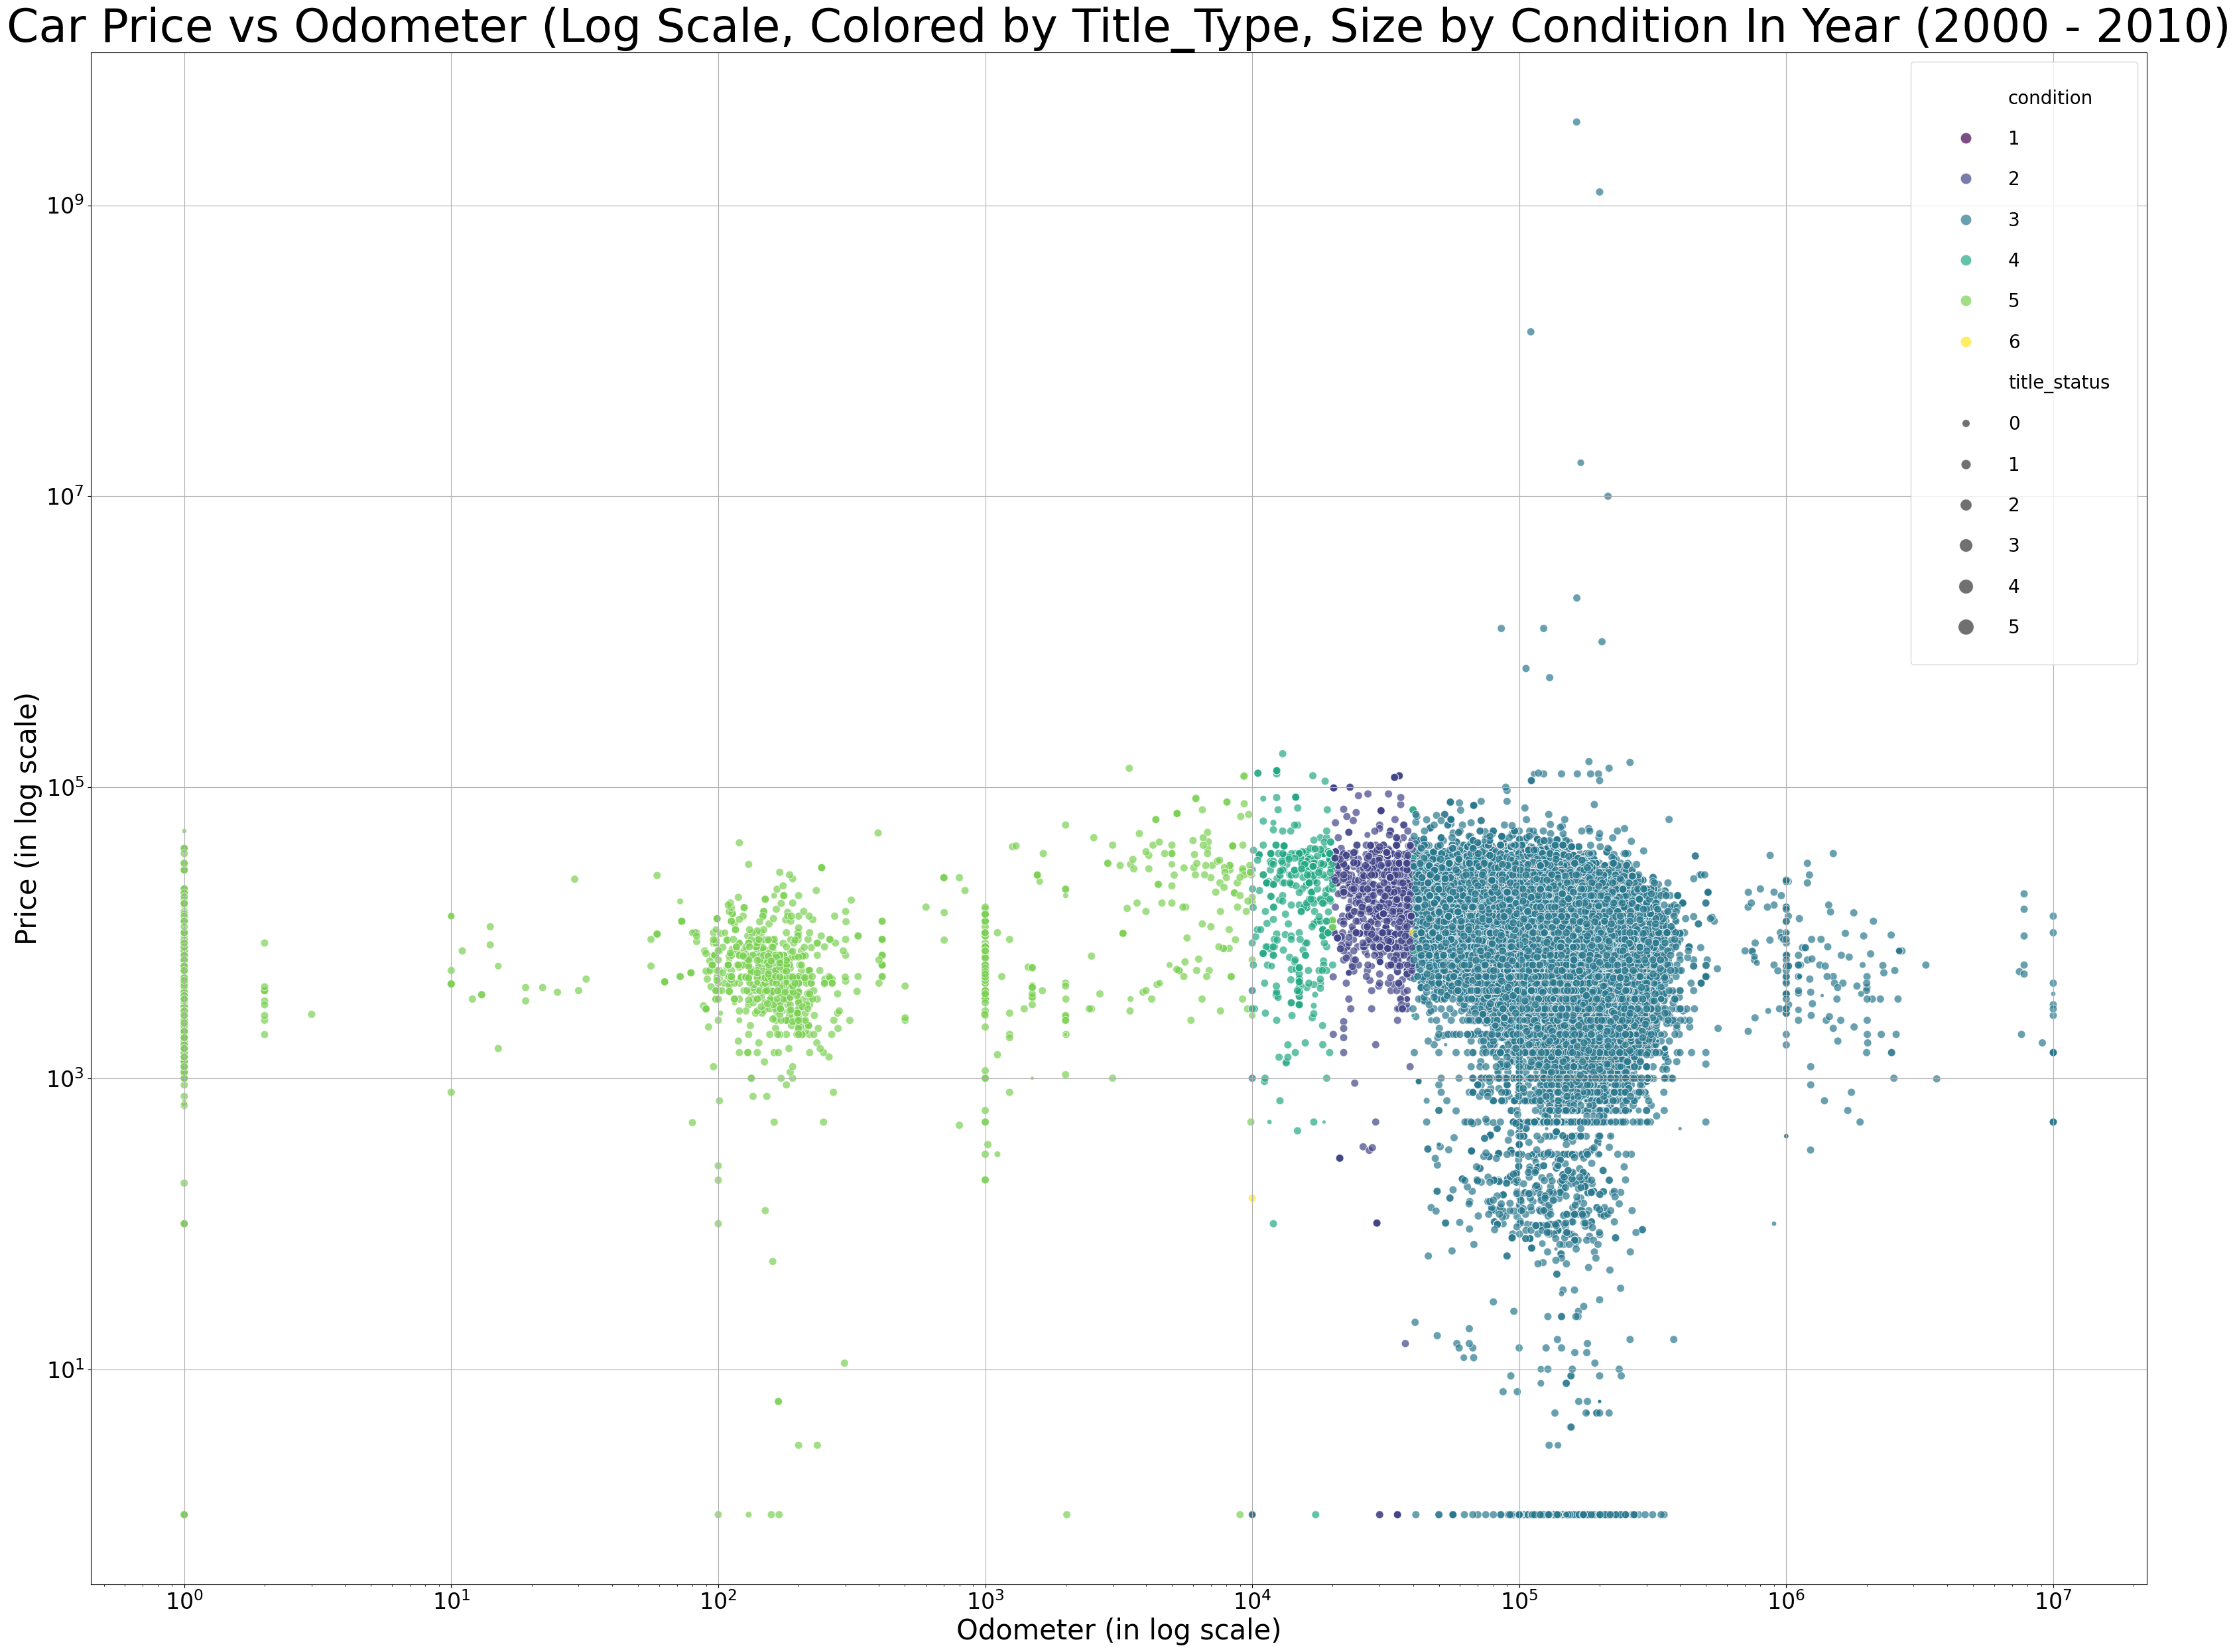

In [132]:
plt = createScatterPlot(cars[cars['year_bin'] == '2010'], '2000 - 2010' )
plt.show()

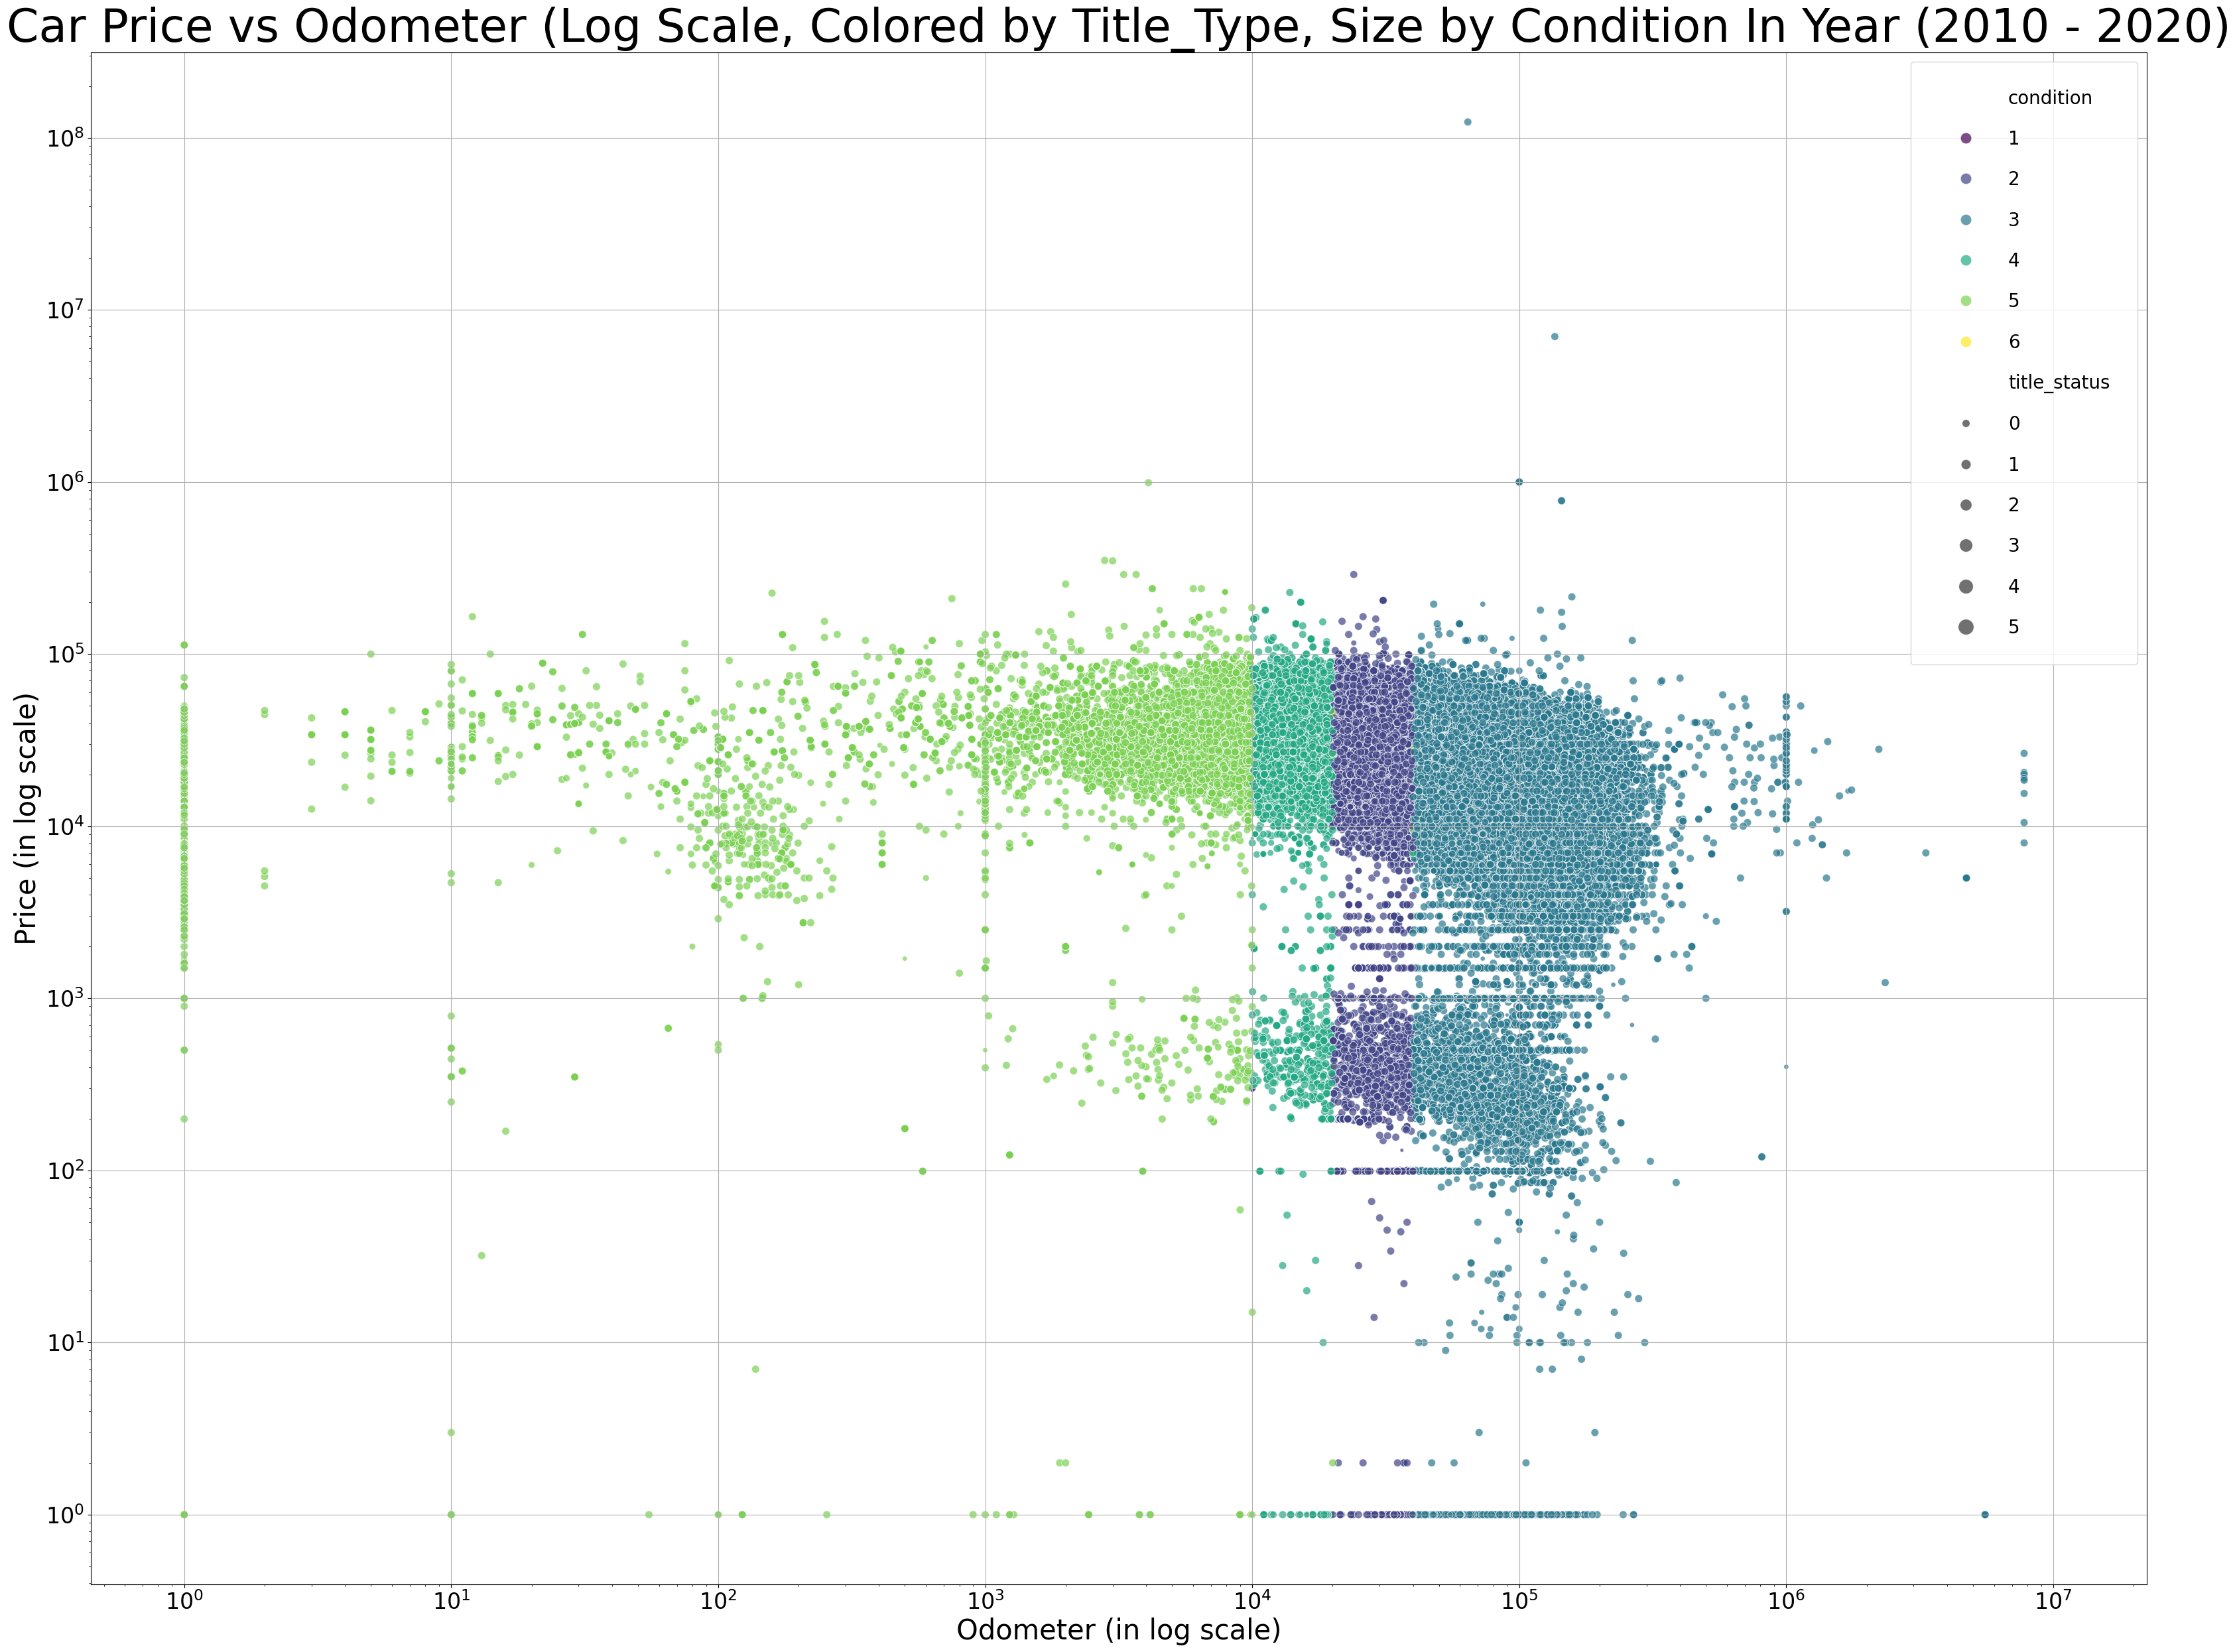

In [133]:
plt1= createScatterPlot(cars[cars['year_bin'] == '2020'], '2010 - 2020')
plt1.show()

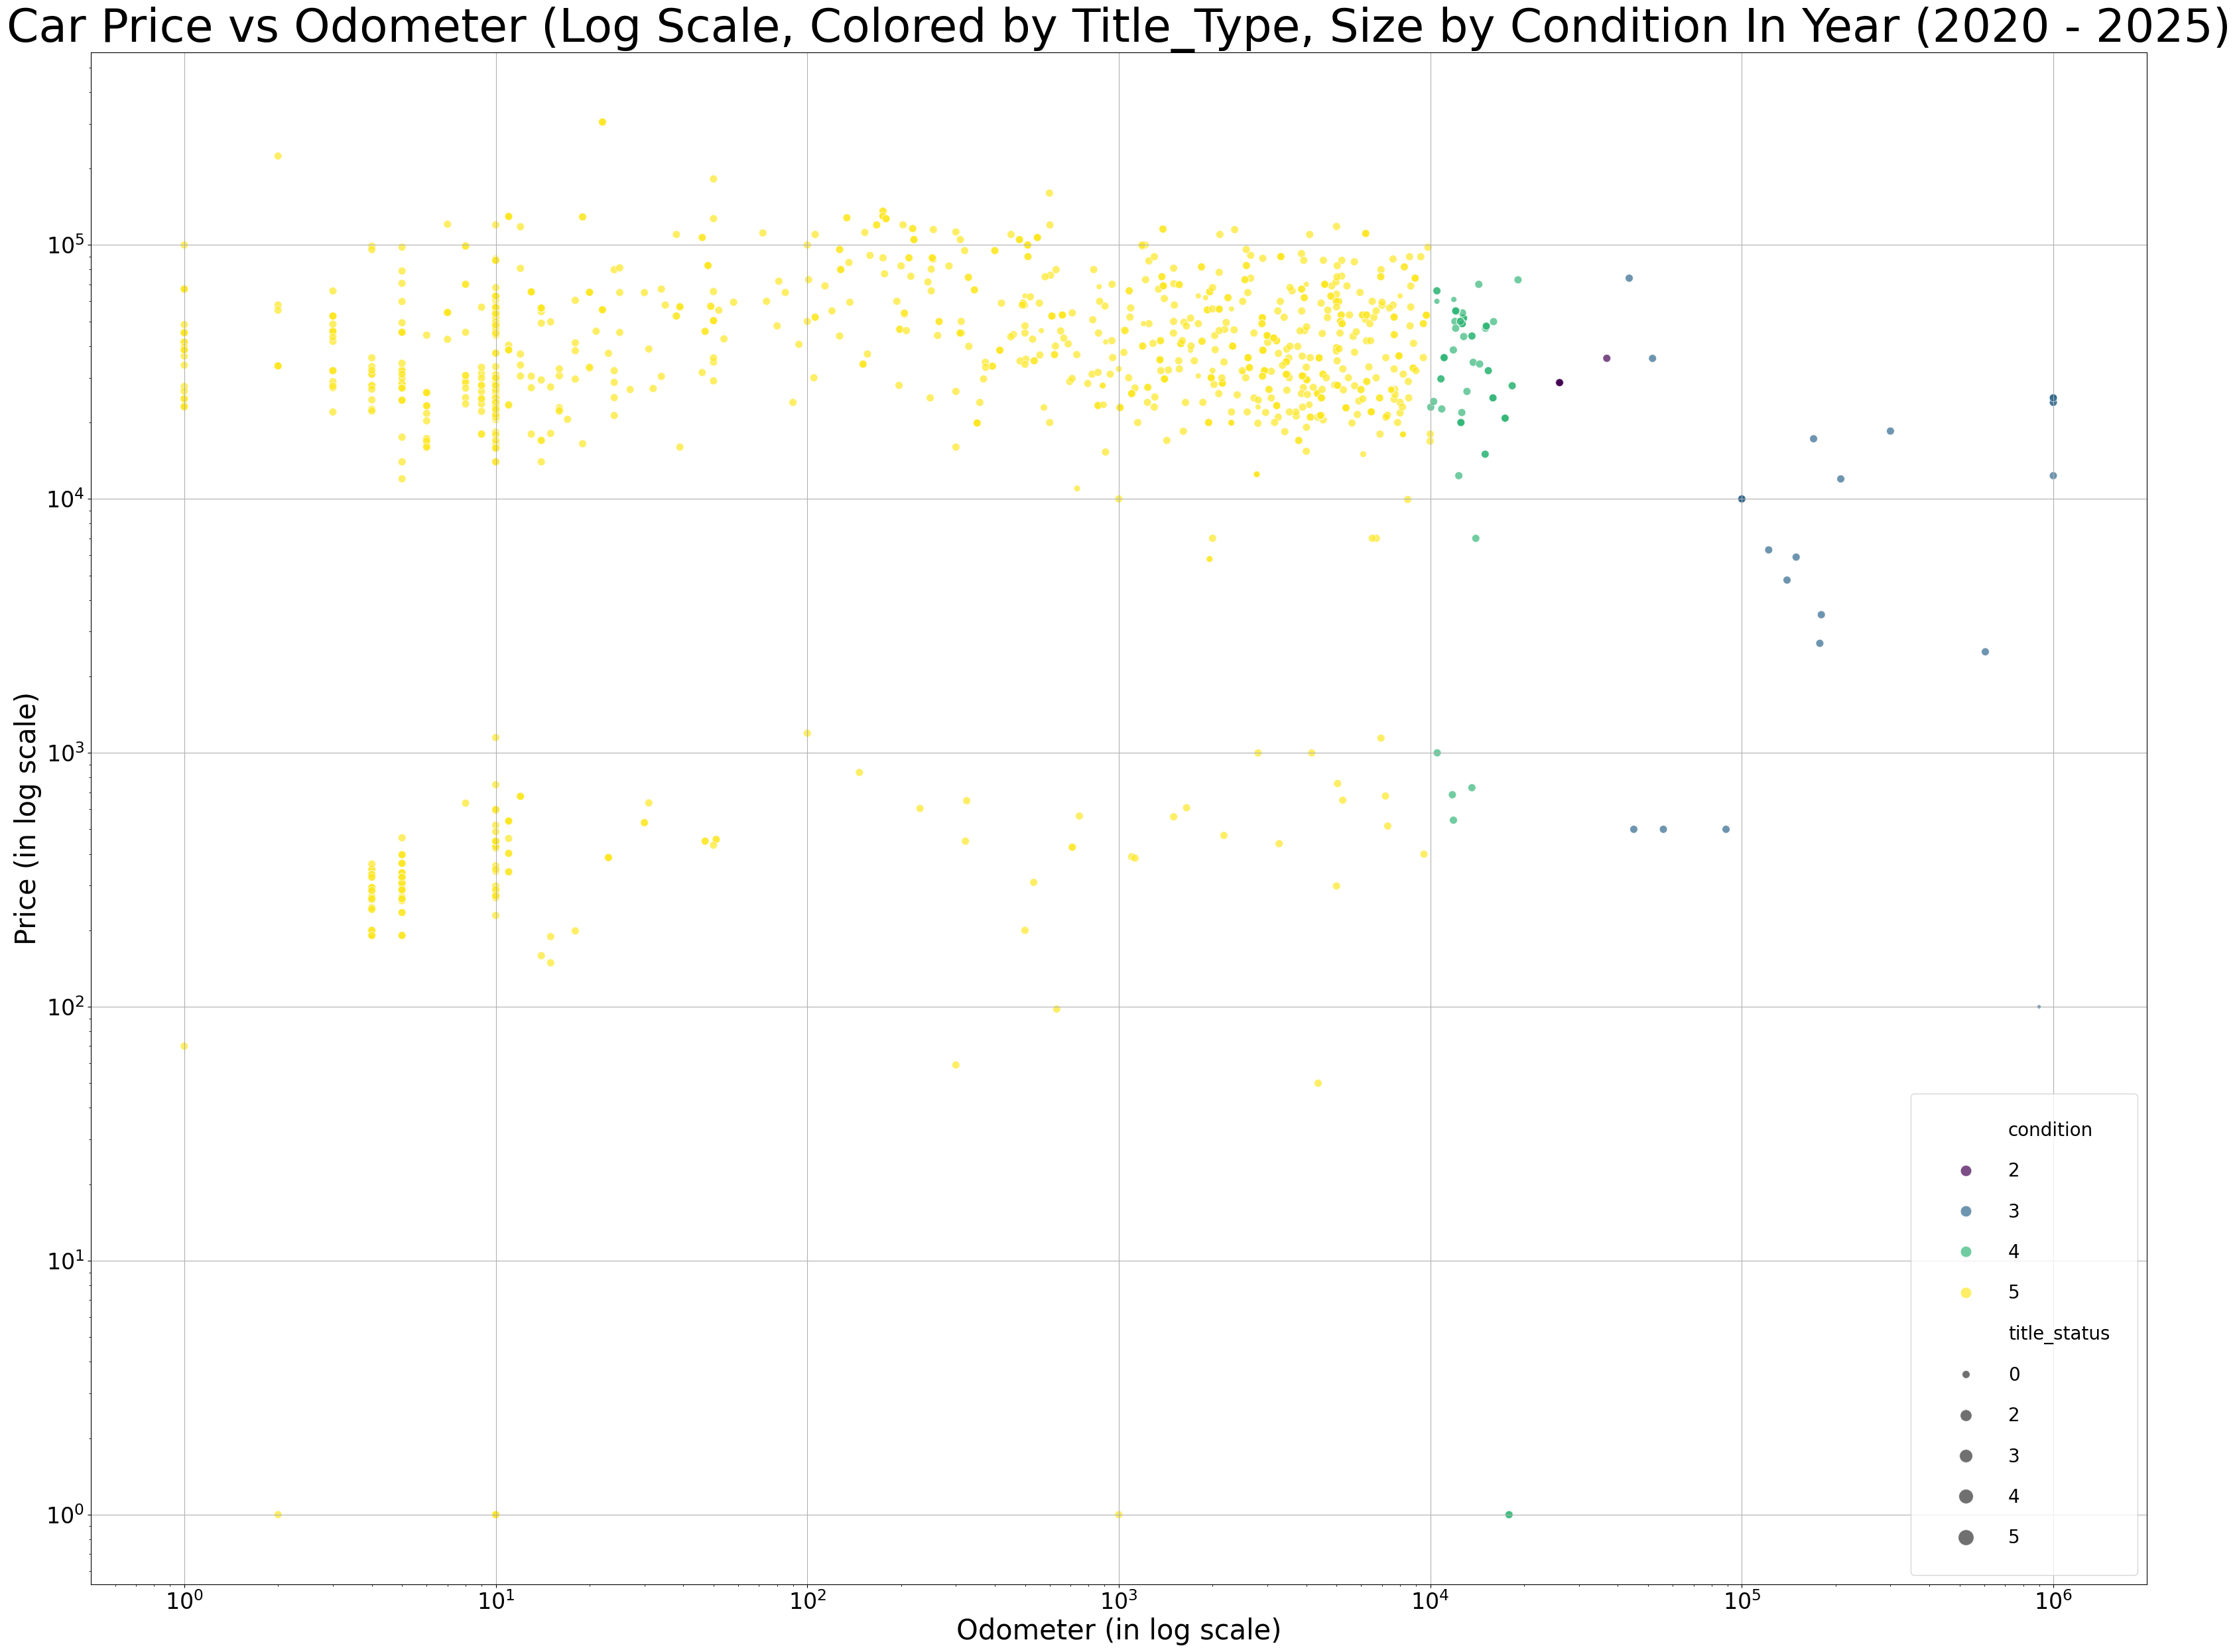

In [216]:

plt2 = createScatterPlot(cars[cars['year_bin'] == '2025'], '2020 - 2025')
plt2.show()

In [ ]:
###############################################################################################################
## Observation ##
## [2020-2025] Prices between 10,000 - 1,00,000, no relation with odometer
## [2010-2020] Prices ranging from 100-1,00,000, no relation with odometer
## [2000-2010] Clustered based on the odometer value either 100-1,000 or >10,000
###############################################################################################################

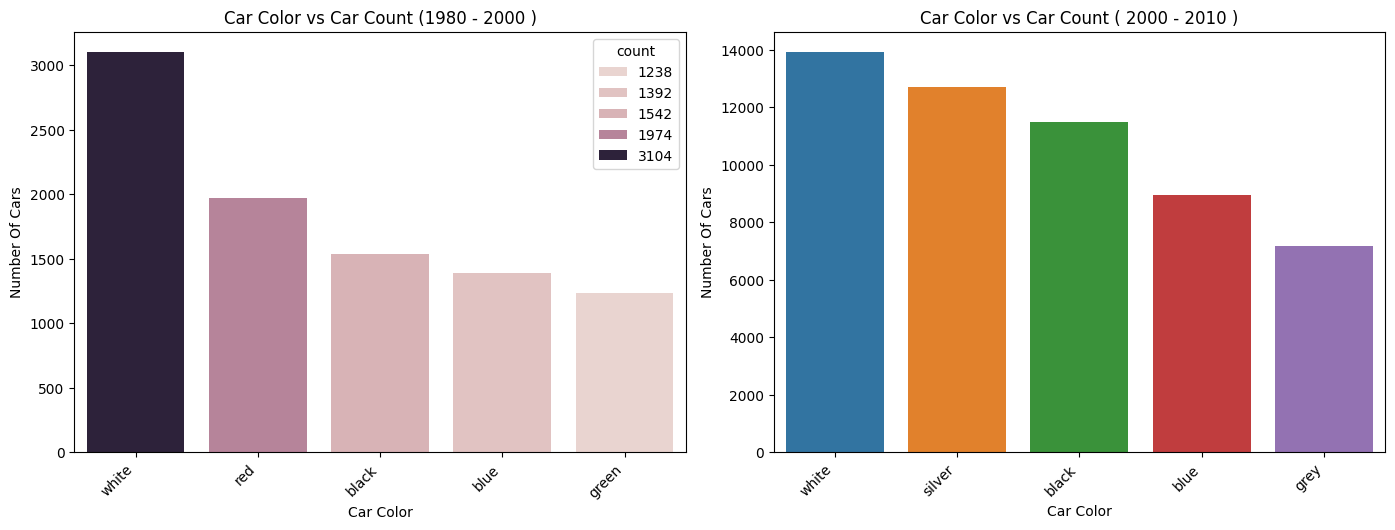

In [118]:
plt.figure(figsize=(70,50))
###############################################################################################################
# Create subplots between choice of car color different year ranges
# Year 1980 - 2000
###############################################################################################################
plt.subplot(10,10,1)
car_color_df = cars[cars['year_bin'] == '2000']['paint_color'].value_counts()[0:5].reset_index()
ax = sns.barplot(data=car_color_df, x='paint_color', y='count', hue='count', legend='auto')
ax.set_xlabel('Car Color')
ax.set_ylabel('Number Of Cars')
ax.set_title('Car Color vs Car Count (1980 - 2000 )')
plt.xticks(rotation=45, ha='right')

###############################################################################################################
# year 2000 - 2010
###############################################################################################################
plt.subplot(10,10,2)
car_color_df = cars[cars['year_bin'] == '2010']['paint_color'].value_counts()[0:5].reset_index()
ax = sns.barplot(data=car_color_df, x='paint_color', y='count', hue='paint_color')
ax.set_xlabel('Car Color')
ax.set_ylabel('Number Of Cars')
ax.set_title('Car Color vs Car Count ( 2000 - 2010 )')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()

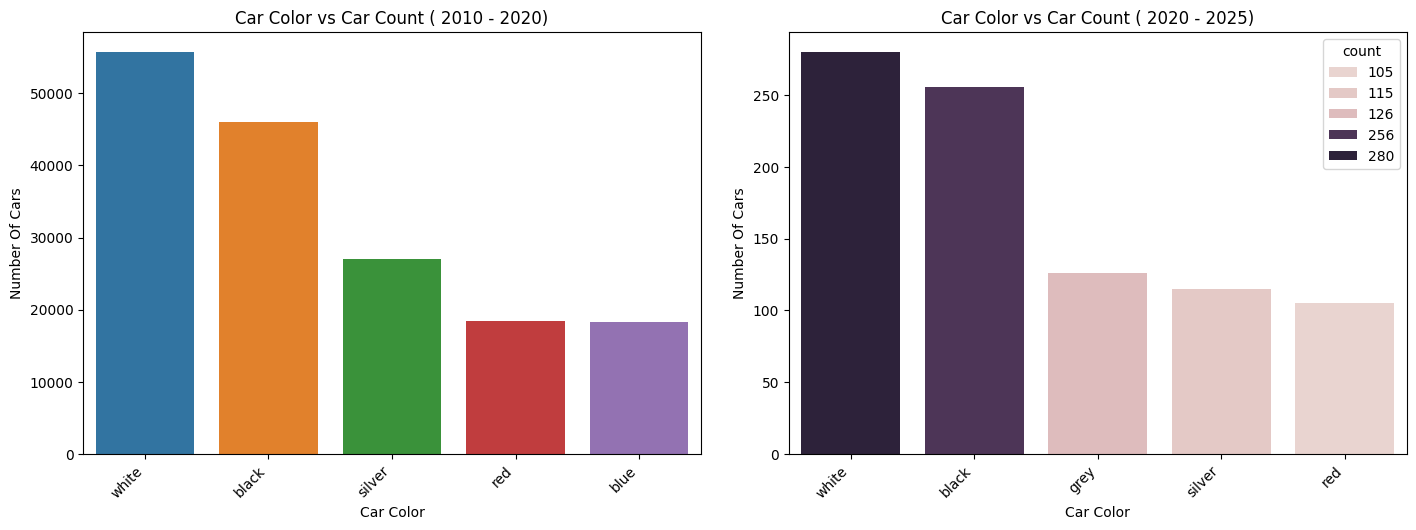

In [119]:
plt.figure(figsize=(70,50))

###############################################################################################################
# year 2010 - 2020
###############################################################################################################

plt.subplot(10,10,3)
car_color_df = cars[cars['year_bin'] == '2020']['paint_color'].value_counts()[0:5].reset_index()
ax = sns.barplot(data=car_color_df, x='paint_color', y='count', hue='paint_color')
ax.set_xlabel('Car Color')
ax.set_ylabel('Number Of Cars')
ax.set_title('Car Color vs Car Count ( 2010 - 2020)')
plt.xticks(rotation=45, ha='right')

###############################################################################################################
# year 2020 - 2025
###############################################################################################################

plt.subplot(10,10,4)
car_color_df = cars[cars['year_bin'] == '2025']['paint_color'].value_counts()[0:5].reset_index()
ax = sns.barplot(data=car_color_df, x='paint_color', y='count', hue='count')
ax.set_xlabel('Car Color')
ax.set_ylabel('Number Of Cars')
ax.set_title('Car Color vs Car Count ( 2020 - 2025)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

In [ ]:
###############################################################################################################
# Observations
###############################################################################################################a
# Car Color priority among used cars for year ranges
# While 
# Black

([0, 1, 2, 3, 4],
 [Text(0, 0, 'ford'),
  Text(1, 0, 'chevrolet'),
  Text(2, 0, 'toyota'),
  Text(3, 0, 'honda'),
  Text(4, 0, 'nissan')])

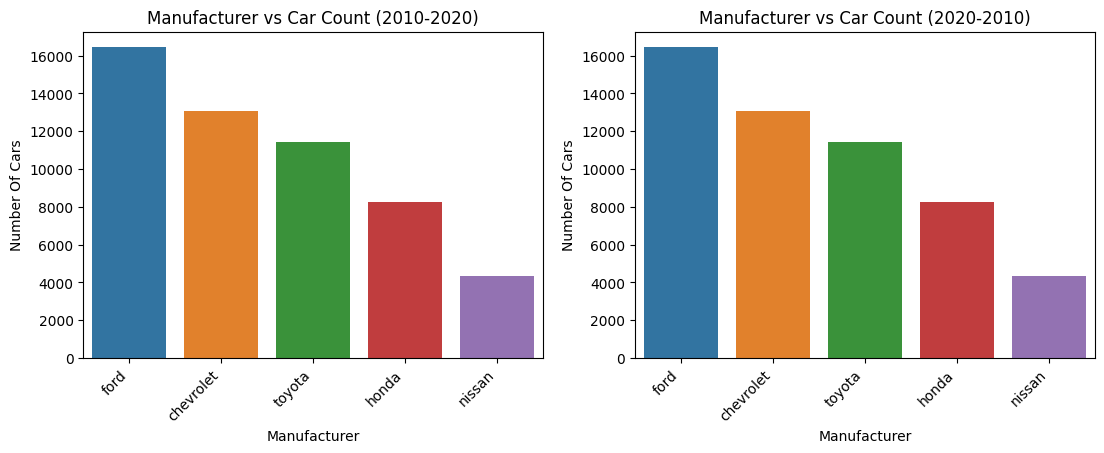

In [117]:
plt.figure(figsize=(70,50))

plt.subplot(10,10,1)
manufacturer_df = cars[cars['year_bin'] == '2010']['manufacturer'].value_counts()[0:5].reset_index()
ax = sns.barplot(data=manufacturer_df, x='manufacturer', y='count', hue='manufacturer')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Number Of Cars')
ax.set_title('Manufacturer vs Car Count (2010-2020)')
plt.xticks(rotation=45, ha='right')

plt.subplot(10,10,2)
car_color_df = cars[cars['year_bin'] == '2020']['manufacturer'].value_counts()[0:5].reset_index()
ax = sns.barplot(data=manufacturer_df, x='manufacturer', y='count', hue='manufacturer')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Number Of Cars')
ax.set_title('Manufacturer vs Car Count (2020-2010)')
plt.xticks(rotation=45, ha='right')



In [ ]:
###############################################################################################################
# Observations
###############################################################################################################a
# Car manufacturer priority for used cars among all year ranges
# Ford
# Chevrlot
# Toyota
# Honda
# Nissan 

<Axes: >

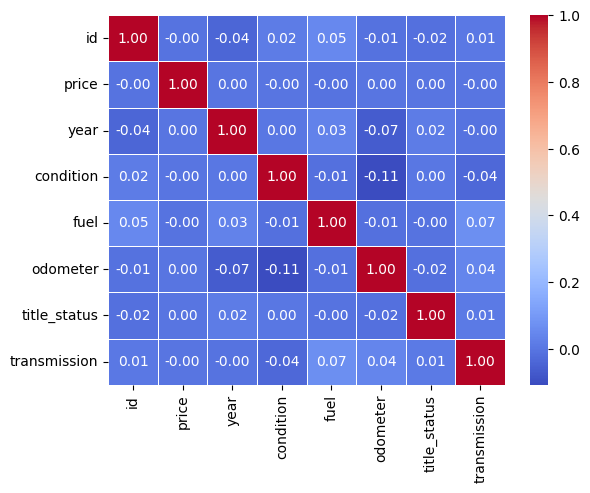

In [64]:
matrix_2010 = cars[cars['year_bin'] == '2010'].corr(numeric_only=True)
sns.heatmap(matrix_2010, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

<Axes: >

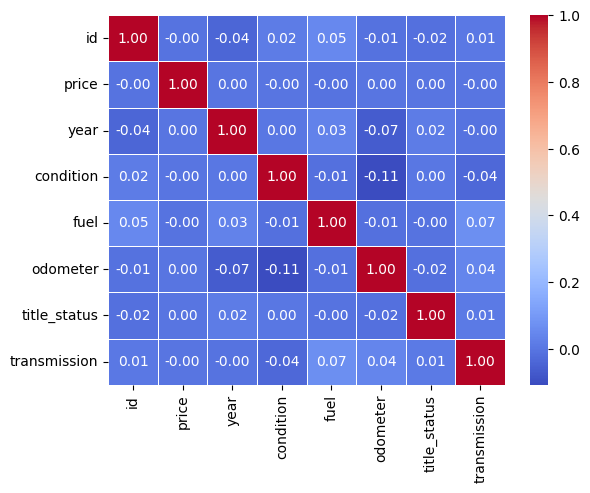

In [63]:

matrix_2020 = cars[cars['year_bin'] == '2020'].corr(numeric_only=True)
sns.heatmap(matrix_2010, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [103]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

### LinearRegression (2010-2020)

* Features Included   : 'Year', 'Condition', 'Fuel', 'Odometer', 'Title Status', 'Transmission', 'Price'
* pipeleline          : 'StandardScaler', 'PloynomialFeatures', 'LinearRegression'
* Hypermeter          : degree (1,2,3), include_bias (False), fit_intercepter (True, False)

In [176]:
# All the cars manufactured between 2010 - 2020
cars_2020 = cars[cars['year_bin'] == '2020']

cars_2020_wt_sel_cols = cars_2020[[ 'year' , 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'price']]

X = cars_2020_wt_sel_cols.drop('price', axis= 1)
y = cars_2020_wt_sel_cols['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.25)

#pipeline
pipeline_lr_20 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# hyper-parameters
param_grid = {
    'poly__degree': [1, 2, 3],
    'poly__include_bias': [False],
    'regressor__fit_intercept': [True, False]
}

grid_lr_20 = GridSearchCV(pipeline_lr_20, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_lr_20.fit(X_train, y_train)

print("Best parameters:", grid_lr_20.best_params_)
print("Best score (R²):", grid_lr_20.best_score_)

Best parameters: {'poly__degree': 3, 'poly__include_bias': False, 'regressor__fit_intercept': False}
Best score (R²): 0.23226456200928736


In [177]:
feature_names_lr_20 = X.columns
best_pipeline = grid_lr_20.best_estimator_

# Get transformed feature names from PolynomialFeatures
poly_lr_20 = best_pipeline.named_steps['poly']
# feature_names = poly.get_feature_names_out(input_features=[f'X{i}' for i in range(X.shape[1])])
feature_names_lr_20 = poly_lr_20.get_feature_names_out(input_features=feature_names_lr_20)

# Get coefficients from the linear regression
coefficients_lr_20 = best_pipeline.named_steps['regressor'].coef_

# Combine feature names and coefficients
feature_importance_lr_20 = pd.DataFrame({
    'Feature': feature_names_lr_20,
    'Coefficient': coefficients_lr_20
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

print(feature_importance_lr_20.head(10))  # Top 10 important features

                            Feature   Coefficient
57             condition odometer^2 -69627.487811
26                   transmission^2  62729.647111
14               condition odometer -42581.851611
82                   transmission^3  31002.839172
35          year condition odometer -14746.887351
2                              fuel -13713.574995
3                          odometer  -7518.143921
59  condition odometer transmission  -6770.581109
7                    year condition  -5747.863565
5                      transmission  -5173.981952


In [178]:
#pipeline by creating best parameters
pipeline_lr_20 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree= 3, include_bias= False)),
    ('regressor', LinearRegression(fit_intercept= False))
])

pipeline_lr_20.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('regressor', LinearRegression(fit_intercept=False))])

### LinearRegression (2000-2010)

* Features Included   : 'Year', 'Condition', 'Fuel', 'Odometer', 'Title Status', 'Transmission', 'Price'
* pipeleline          : 'StandardScaler', 'PloynomialFeatures', 'LinearRegression'
* Hypermeter          : degree (1,2,3), include_bias (False), fit_intercepter (True, False)

In [184]:
# All the cars manufactured between 2010 - 2020
cars_2010 = cars[cars['year_bin'] == '2010']

cars_2010_wt_sel_cols = cars_2010[[ 'year' , 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'price']]

X = cars_2010_wt_sel_cols.drop('price', axis= 1)
y = cars_2010_wt_sel_cols['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.25)

#pipeline
pipeline_lr_10 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# hyper-parameters
param_grid_lr_10 = {
    'poly__degree': [1, 2, 3],
    'poly__include_bias': [False],
    'regressor__fit_intercept': [True, False]
}

grid_lr_10 = GridSearchCV(pipeline_lr_10, param_grid_lr_10, cv=5, scoring='r2', n_jobs=-1)
grid_lr_10.fit(X_train, y_train)

print("Best parameters:", grid_lr_10.best_params_)
print("Best score (R²):", grid_lr_10.best_score_)

Best parameters: {'poly__degree': 1, 'poly__include_bias': False, 'regressor__fit_intercept': False}
Best score (R²): -9.471433025187675


In [188]:
feature_names = X.columns
best_pipeline_lr_10 = grid_lr_10.best_estimator_

# Get transformed feature names from PolynomialFeatures
poly_lr_10 = best_pipeline_lr_10.named_steps['poly']
# feature_names = poly.get_feature_names_out(input_features=[f'X{i}' for i in range(X.shape[1])])
feature_names_lr_10 = poly_lr_10.get_feature_names_out(input_features=feature_names)

# Get coefficients from the linear regression
coefficients_lr_10 = best_pipeline_lr_10.named_steps['regressor'].coef_

# Combine feature names and coefficients
feature_importance_lr_10 = pd.DataFrame({
    'Feature': feature_names_lr_10,
    'Coefficient': coefficients_lr_10
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

print(feature_importance_lr_10.head(10))  # Top 10 important features

        Feature   Coefficient
2          fuel -69081.460875
5  transmission -22057.594825
4  title_status  10690.844491
0          year  10643.325990
3      odometer   9604.339920
1     condition  -8370.845066


In [203]:
#pipeline by creating best parameters
pipeline_lr_10 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree= 1, include_bias= False)),
    ('regressor', LinearRegression(fit_intercept= False))
])

pipeline_lr_10.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('regressor', LinearRegression(fit_intercept=False))])

### RidgeCV (2010-2020)

* Features Included   : 'Year', 'Condition', 'Fuel', 'Odometer', 'Title Status', 'Transmission', 'Price'
* pipeleline          : 'StandardScaler', 'PloynomialFeatures', 'RidgeCV'
* Hypermeter          : alpha (np.logspace(-3, 3, 10))

In [205]:

# All the cars manufactured between 2010 - 2020
cars_2020 = cars[cars['year_bin'] == '2020']

cars_2020_wt_sel_cols = cars_2020[[ 'year' , 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'price']]

X = cars_2020_wt_sel_cols.drop('price', axis= 1)
y = cars_2020_wt_sel_cols['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.25)

feature_names = X.columns

# Choose alphas (regularization strength)
alphas_rcv_20 = np.logspace(-3, 3, 10)

# RidgeCV
model_rcv_20 = RidgeCV(alphas=alphas_rcv_20, store_cv_values=True) 

pipeline_rcv_20 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', model_rcv_20)
])

pipeline_rcv_20.fit(X_train, y_train)

# Get polynomial feature names
poly_features_rcv_20 = pipeline_rcv_20.named_steps['poly'].get_feature_names_out(input_features=feature_names)

# Get coefficients from Ridge or Lasso
coefs_rcv_20 = pipeline_rcv_20.named_steps['ridge'].coef_

# Combine into a DataFrame
coef_df = pd.DataFrame({
    'Feature': poly_features_rcv_20,
    'Coefficient': coefs_rcv_20
})

# Sort by importance
important_features_rcv_20 = coef_df.loc[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=np.abs, ascending=False)

print(important_features_rcv_20.head(10))

                            Feature   Coefficient
57             condition odometer^2 -64564.451719
14               condition odometer -38237.081637
35          year condition odometer -14565.743448
2                              fuel -13712.579843
3                          odometer  -7243.560405
59  condition odometer transmission  -6864.426193
7                    year condition  -5662.178077
16           condition transmission  -4414.670910
21                       odometer^2  -3687.630605
50             condition^2 odometer  -3516.617023


### RidgeCV (2000-2010) 

* Year Range          : 2000-2010 
* Features Included   : 'Year', 'Condition', 'Fuel', 'Odometer', 'Title Status', 'Transmission', 'Price'
* pipeleline          : 'StandardScaler', 'PloynomialFeatures', 'RidgeCV'
* Hypermeter          : alpha (np.logspace(-3, 3, 10))

In [211]:
# All the cars manufactured between 2000 - 2010
cars_2010 = cars[cars['year_bin'] == '2010']

cars_2010_wt_sel_cols = cars_2010[[ 'year' , 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'price']]

X = cars_2010_wt_sel_cols.drop('price', axis= 1)
y = cars_2010_wt_sel_cols['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.25)

feature_names = X.columns

# Choose alphas (regularization strength)
alphas_rcv_10 = np.logspace(-3, 3, 10)

# RidgeCV
model_rcv_10 = RidgeCV(alphas=alphas_rcv_10, store_cv_values=True) 

pipeline_rcv_10 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('ridge', model_rcv_10)
])

pipeline_rcv_10.fit(X_train, y_train)

# Get polynomial feature names
poly_features_rcv_10 = pipeline_rcv_10.named_steps['poly'].get_feature_names_out(input_features=feature_names)

# Get coefficients from Ridge or Lasso
coefs_rcv_10 = pipeline_rcv_10.named_steps['ridge'].coef_

# Combine into a DataFrame
coef_df_rcv_10 = pd.DataFrame({
    'Feature': poly_features_rcv_10,
    'Coefficient': coefs_rcv_10
})

# Sort by importance
important_features_rcv_10 = coef_df_rcv_10.loc[coef_df_rcv_10['Coefficient'] != 0].sort_values(by='Coefficient', key=np.abs, ascending=False)

print(important_features_rcv_10.head(10))

        Feature   Coefficient
2          fuel -68182.847606
5  transmission -21820.810879
4  title_status  10552.630861
0          year  10466.285678
3      odometer   9478.117371
1     condition  -8255.922832


### LassoCV (2010-2020) 

* Year Range          : 2010-2020 
* Features Included   : 'Year', 'Condition', 'Fuel', 'Odometer', 'Title Status', 'Transmission', 'Price'
* pipeleline          : 'StandardScaler', 'PloynomialFeatures', 'RidgeCV'
* Hypermeter          : alpha - (np.logspace(-3, 3, 10)) , cv - 5

In [212]:
# All the cars manufactured between 2010 - 2020
cars_2020 = cars[cars['year_bin'] == '2020']
cars_2020_wt_sel_cols = cars_2020[[ 'year' , 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'price']]

X = cars_2020_wt_sel_cols.drop('price', axis= 1)
y = cars_2020_wt_sel_cols['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.25)

feature_names = X.columns

# Choose alphas (regularization strength)
alphas_lcv_20 = np.logspace(-3, 3, 10)

# Change RidgeCV to LassoCV for sparse feature selection
model_lcv_20 = LassoCV(alphas=alphas_lcv_20, cv=5) 

pipeline_lcv_20 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('reg', model_lcv_20)
])

pipeline_lcv_20.fit(X_train, y_train)
# Get polynomial feature names
poly_features_lcv_20 = pipeline_lcv_20.named_steps['poly'].get_feature_names_out(input_features=feature_names)

# Get coefficients from Ridge or Lasso
coefs_lcv_20 = pipeline_lcv_20.named_steps['reg'].coef_

# Combine into a DataFrame
coef_df_lcv_20 = pd.DataFrame({
    'Feature': poly_features_lcv_20,
    'Coefficient': coefs_lcv_20
})

# Sort by importance
important_features_lcv_20 = coef_df_lcv_20.loc[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=np.abs, ascending=False)

print(important_features_lcv_20.head(10))

                            Feature   Coefficient
2                              fuel -13592.451017
14               condition odometer  13378.182650
35          year condition odometer  -9790.440596
59  condition odometer transmission  -9091.919383
1                         condition   8227.076709
16           condition transmission  -5674.990909
0                              year   3766.499911
7                    year condition  -3434.508933
12                      condition^2   3152.929666
4                      title_status   2910.913849


### LassoCV (2000-2010) 

* Year Range          : 2000-2010 
* Features Included   : 'Year', 'Condition', 'Fuel', 'Odometer', 'Title Status', 'Transmission', 'Price'
* pipeleline          : 'StandardScaler', 'PloynomialFeatures', 'RidgeCV'
* Hypermeter          : alpha - (np.logspace(-3, 3, 10)) , cv - 5

In [213]:
# All the cars manufactured between 2010 - 2020
cars_2010 = cars[cars['year_bin'] == '2010']
cars_2010_wt_sel_cols = cars_2010[[ 'year' , 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'price']]

X = cars_2010_wt_sel_cols.drop('price', axis= 1)
y = cars_2010_wt_sel_cols['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, test_size=0.25)
feature_names = X.columns

# Choose alphas (regularization strength)
alphas_lcv_10 = np.logspace(-3, 3, 10)

# Change RidgeCV to LassoCV for sparse feature selection
model_lcv_10 = LassoCV(alphas=alphas_lcv_10, cv=5) 

pipeline_lcv_10 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('reg', model_lcv_10)
])

pipeline_lcv_10.fit(X_train, y_train)
# Get polynomial feature names
poly_features_lcv_10 = pipeline_lcv_10.named_steps['poly'].get_feature_names_out(input_features=feature_names)

# Get coefficients from Ridge or Lasso
coefs_lcv_10 = pipeline_lcv_10.named_steps['reg'].coef_

# Combine into a DataFrame
coef_df_lcv_10 = pd.DataFrame({
    'Feature': poly_features_lcv_10,
    'Coefficient': coefs_lcv_10
})

# Sort by importance
important_features_lcv_10 = coef_df_lcv_10.loc[coef_df_lcv_10['Coefficient'] != 0].sort_values(by='Coefficient', key=np.abs, ascending=False)

print(important_features_lcv_10.head(10))

                            Feature   Coefficient
20                fuel transmission  1.081598e+06
5                      transmission -2.925253e+05
72              fuel transmission^2  2.337219e+05
35          year condition odometer  2.290123e+05
59  condition odometer transmission -1.961323e+05
7                    year condition  1.677799e+05
26                   transmission^2 -1.592549e+05
69       fuel odometer transmission  1.370487e+05
1                         condition -1.183084e+05
23            odometer transmission  1.173646e+05


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### LinearRegression (2010-2020)

In [173]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [174]:
# Predictions
y_train_pred = pipeline_lr_20.predict(X_train)
y_test_pred = pipeline_lr_20.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R²: {r2_train:.4f}")
print(f"Testing R²: {r2_test:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")

Training R²: 0.0009
Testing R²: -1565.9644
Training RMSE: 14376611.9366
Testing RMSE: 420988.7338


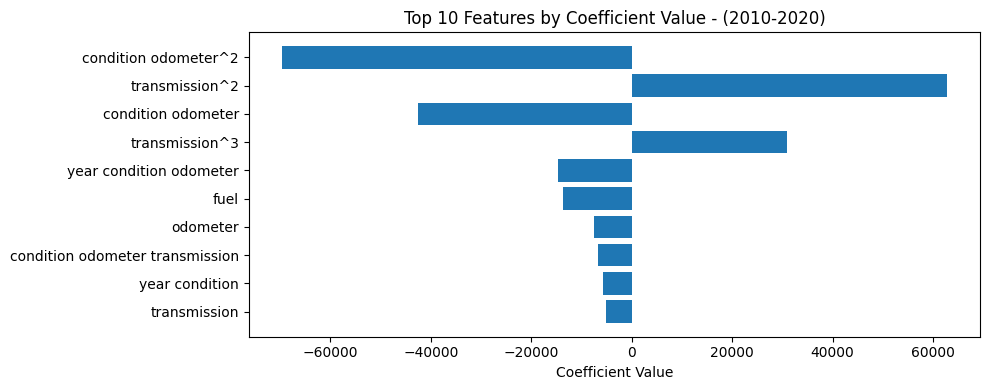

In [198]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot
plt.figure(figsize=(10, 4))
plt.barh(feature_importance_lr_20[:10]['Feature'], feature_importance_lr_20[:10]['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Value - (2010-2020)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

### LinearRegression (2000-2010)

In [ ]:
# Predictions
y_train_pred = pipeline_lr_20.predict(X_train)
y_test_pred = pipeline_lr_20.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R²: {r2_train:.4f}")
print(f"Testing R²: {r2_test:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")

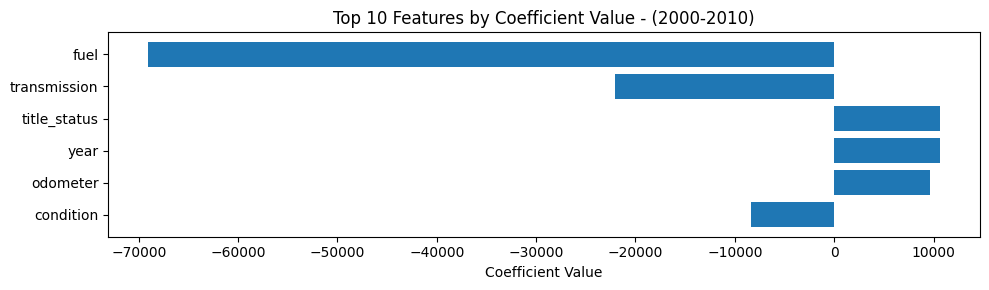

In [197]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot
plt.figure(figsize=(10, 3))
plt.barh(feature_importance_lr_10.head(10)['Feature'], feature_importance_lr_10.head(10)['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Value - (2000-2010)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

### RidgeCV  (2010-2020)

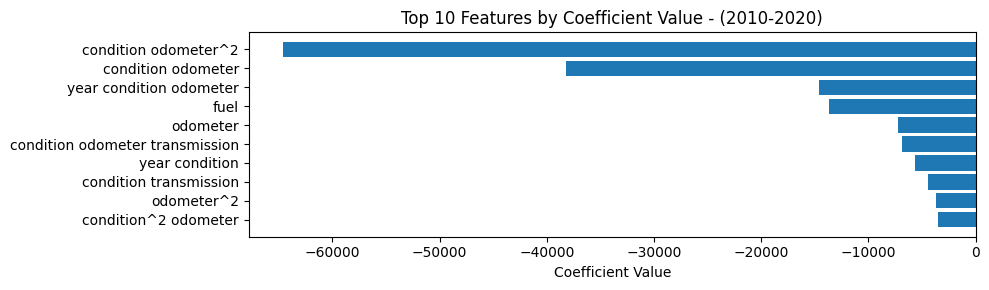

In [202]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot
plt.figure(figsize=(10, 3))
plt.barh(important_features_rcv_20.head(10)['Feature'], important_features_rcv_20.head(10)['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Value - (2010-2020)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

### RidgeCV  (2000-2010)

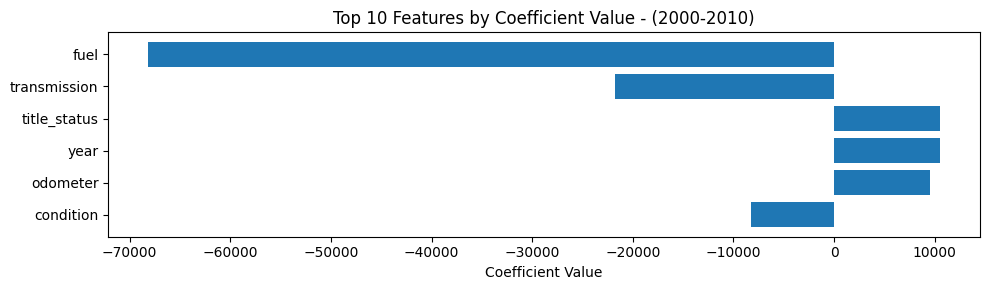

In [207]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot
plt.figure(figsize=(10, 3))
plt.barh(important_features_rcv_10.head(10)['Feature'], important_features_rcv_10.head(10)['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Value - (2000-2010)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

### LassoCV  (2010-2020)

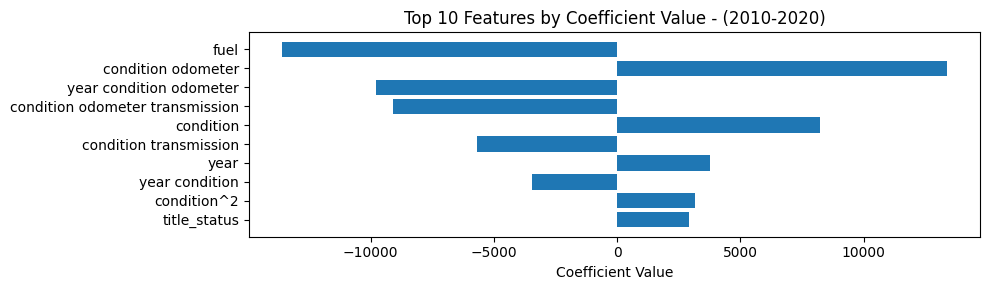

In [214]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot
plt.figure(figsize=(10, 3))
plt.barh(important_features_lcv_20.head(10)['Feature'], important_features_lcv_20.head(10)['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Value - (2010-2020)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

### RidgeCV  (2000-2010)

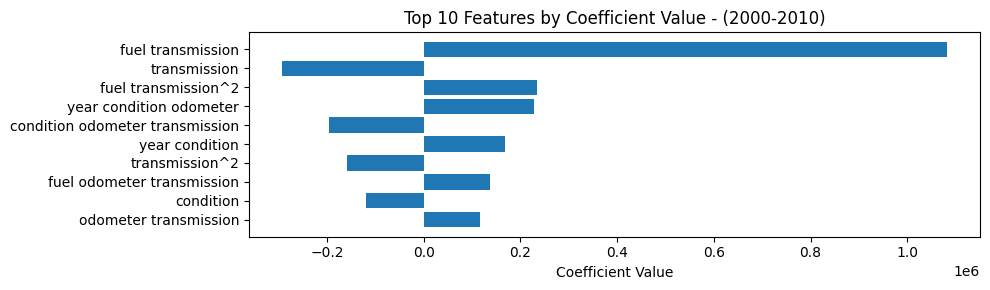

In [215]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot
plt.figure(figsize=(10, 3))
plt.barh(important_features_lcv_10.head(10)['Feature'], important_features_lcv_10.head(10)['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features by Coefficient Value - (2000-2010)')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.